imports

In [1]:
import loss_landscapes
import torch
from HGNN.train import CNN, dataLoader
from HGNN.train.configParser import ConfigParser, getModelName
import os
import numpy as np
from tqdm.auto import tqdm 
import json
import random

import matplotlib.pyplot as plt
from myhelpers import config_plots
config_plots.global_settings()

import loss_surface_plotter
import BGNN_loss
from myhelpers import TrialStatistics

cuda

In [2]:
cuda=5

# set cuda
if torch.cuda.is_available():
    torch.cuda.set_device(cuda)
    print("using cuda", cuda)

using cuda 5


Constants

In [3]:
# generat coord_Tracker_path
dataPath = "/raid/elhamod/Fish"
experimentsPath = "/home/elhamod/HGNN/experiments/" 
trial_hashes = {
    "biology_paper_surfaceExperiments_HGNN_datasets": [
        ["af109a6b3598cfb56a4f87b4ab1167d63ec855654e268e5ebb3f2593", "15 images per species"],
        ["25a3493e446bc11178030e9840a44c162fdc033880d10feb03803e27", "50 images per species"],
        ["93d7e3b6e826a325d15ec544fceea58979039027d0a28726435035e6", "200 images per species"],
    ]
} # dictionary of experiments and their [trial hashes, title]


normalize = 'layer'
Do_pca = True # If true, best fitting plane will be found. If false, a random plane will be generated.
STEPS = 20 # resolution of the grid (steps*steps) ALWAYS EVEN
loader_id="train" # 'test', 'train'
DISTANCE=None # None
plot_all_on_same_scale=True # plots all figures on same scale and saves to a separate file with a hash

helper function

In [4]:
def get_model_path(experimentPathAndName, model_hash):
    return os.path.join(experimentPathAndName, "models", model_hash)

def get_model_params(experimentPathAndName, model_hash):
    full_path = os.path.join(get_model_path(experimentPathAndName, model_hash), "params.json")
    with open(full_path) as f:
        experiment_params = json.load(f)
    return experiment_params

In [5]:
def plot_surface_data(loss_data, models, coord_Tracker, title, maxVal=None, minVal=None):
    if maxVal is None:
        maxVal = np.amax([loss_data])
    if minVal is None:
        minVal = np.amin([loss_data])
    
    num_rows=1
    num_columns=1
    STEPS = coord_Tracker.steps_
    DISTANCE = coord_Tracker.dist_

    f, axes = plt.subplots(num_rows, num_columns, figsize=(40, 15), dpi= 300,)

    X = np.array([(k - int(STEPS/2))*DISTANCE/STEPS for k in range(STEPS+1)])
    # X = np.array([(k - int(STEPS/2)) for k in range(STEPS+1)])
    Y = X

    # plot contoues and heatmap
    ax = plt.subplot(num_rows, num_columns, 1)
    contours = plt.contour(X, Y, loss_data, 15, colors='black') # 
    plt.clabel(contours, inline=True, fontsize=10)
    plt.imshow(loss_data, extent=[X[0], X[-1], Y[0], Y[-1]], origin='lower') # , cmap='RdGy', alpha=0.5
    plt.pcolor(X, Y, loss_data, vmin=minVal, vmax=maxVal, cmap='Reds')
    plt.colorbar()

    ax.title.set_text(title) 

    # plot optimzation path
    wm_center = loss_landscapes.wrap_model(models[-1]).get_module_parameters()
    for i in range(len(models)):
        wm_ = loss_landscapes.wrap_model(models[i])
        wm = wm_.get_module_parameters()
        scaled_model = loss_surface_plotter.scale_model(wm, wm_center, coord_Tracker.scaled_dirs_, normalize, DISTANCE, STEPS)
        plt.plot(scaled_model[0], scaled_model[1], marker='o', markersize=4, color="blue")
        value = round(metric(wm_).item(),2)
        if i%10 == 0 or i==len(models)-1:
            plt.text(scaled_model[0], scaled_model[1], value, fontdict={'size'   : 15})
    
    return f

In [6]:
def get_loss_params(loader):
    loader = torch.utils.data.DataLoader(loader.dataset, batch_size=len(loader.dataset))
    batch = next(iter(loader))
    inputs = batch["image"]
    target = batch["fine"]
    meta_target = batch["coarse"]
    return inputs, target, meta_target


def get_loader(loader_id):
    if loader_id == 'validation':
        loader = validation_loader
    elif loader_id == 'test':
        loader = test_loader
    else:
        loader = train_loader
    return get_loss_params(loader)

Loop through hashes and generate the plots

In [7]:
max_ = None
min_= None

# for all experiments
for experimentName, trial_hashes_ in tqdm(trial_hashes.items(), desc="experiment"):
    print("Experiment: ", experimentName)
    
    experimentPathAndName = os.path.join(experimentsPath, experimentName)
    config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
    
    # For all models
    for hash_ in tqdm(trial_hashes_, desc="hash"):
        
        hash_, title_ = hash_
        print("Hash: ", hash_)
        
        # Get experiment parameters
        experiment_params = get_model_params(experimentPathAndName, hash_)
        datasetManager.updateParams(config_parser.fixPaths(experiment_params))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        architecture = {
            "fine": len(train_loader.dataset.csv_processor.getFineList()),
            "coarse" : len(train_loader.dataset.csv_processor.getCoarseList())
        }
        
        # Create paths for savign resutls
        model_path = get_model_path(experimentPathAndName, hash_)
        coord_Tracker_path = os.path.join(model_path, 'coordinates', normalize, str(STEPS), str(DISTANCE), loader_id)
        pca_path = os.path.join(model_path, 'coordinates')
        if not os.path.exists(coord_Tracker_path):
            os.makedirs(coord_Tracker_path)

        # get optimization path models
        model_root_path = os.path.join(experimentPathAndName, "models", hash_)
        model_paths = loss_surface_plotter.fetch_model_paths(model_root_path)
        models = loss_surface_plotter.get_models(model_paths, architecture, experiment_params)
        
        inputs, target, meta_target = get_loader(loader_id)
        metric = BGNN_loss.BGNN_loss_oneBatch(inputs, target, meta_target, experiment_params["lambda"], False)
        
        coord_Tracker = loss_landscapes.Coordinates_tracker(path=coord_Tracker_path, dirs_path=pca_path, steps_=STEPS, dist_=DISTANCE)                  

        # Get projections
        if Do_pca:
            if not coord_Tracker.load_dirs():
                coord_Tracker.update_directions(loss_landscapes.get_best_fit_orthogonal_bases_pca(models))
                coord_Tracker.save()
                print("PCA plane basis saved")
            else:
                print("PCA plane basis loaded")

        # Calculate loss data            
        loss_data_file = os.path.join(coord_Tracker_path, "loss_surface_data")
        try:
            loss_data = np.load(loss_data_file+'.npy')
            coord_Tracker.load()
            print("loss surface data  loaded")
        except:
            loss_data = loss_landscapes.random_plane(models[-1], metric, normalization=normalize, deepcopy_model=True, coord_Tracker=coord_Tracker, other_models=models[:-1])
            np.save(loss_data_file, loss_data)
            print("loss surface data  saved")
            
        # Keep track of the max/min values to plot all on same scale?
        if plot_all_on_same_scale:
            maxVal = np.amax([loss_data])
            if max_ is None or maxVal > max_:
                max_ = maxVal
            minVal = np.amin([loss_data])
            if min_ is None or minVal < min_:
                min_ = minVal

Experiment:  biology_paper_surfaceExperiments_HGNN_datasets


Hash:  af109a6b3598cfb56a4f87b4ab1167d63ec855654e268e5ebb3f2593
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
39  models added



PCA plane basis loaded
0.09003107519520293
loss surface data  loaded
Hash:  25a3493e446bc11178030e9840a44c162fdc033880d10feb03803e27
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
27  models added



PCA plane basis loaded
0.12503157088240568
loss surface data  loaded
Hash:  93d7e3b6e826a325d15ec544fceea58979039027d0a28726435035e6
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
40  models added



PCA plane basis loaded
0.36262182425848694
loss surface data  loaded




Experiment:  biology_paper_surfaceExperiments_HGNN_datasets


Hash:  af109a6b3598cfb56a4f87b4ab1167d63ec855654e268e5ebb3f2593
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
39  models added



0.09003107519520293
loss surface data  loaded
Hash:  25a3493e446bc11178030e9840a44c162fdc033880d10feb03803e27
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
27  models added



0.12503157088240568
loss surface data  loaded
Hash:  93d7e3b6e826a325d15ec544fceea58979039027d0a28726435035e6
Creating datasets...
Creating datasets... Done.
Creating loaders...
Creating loaders... Done.
40  models added



0.36262182425848694
loss surface data  loaded




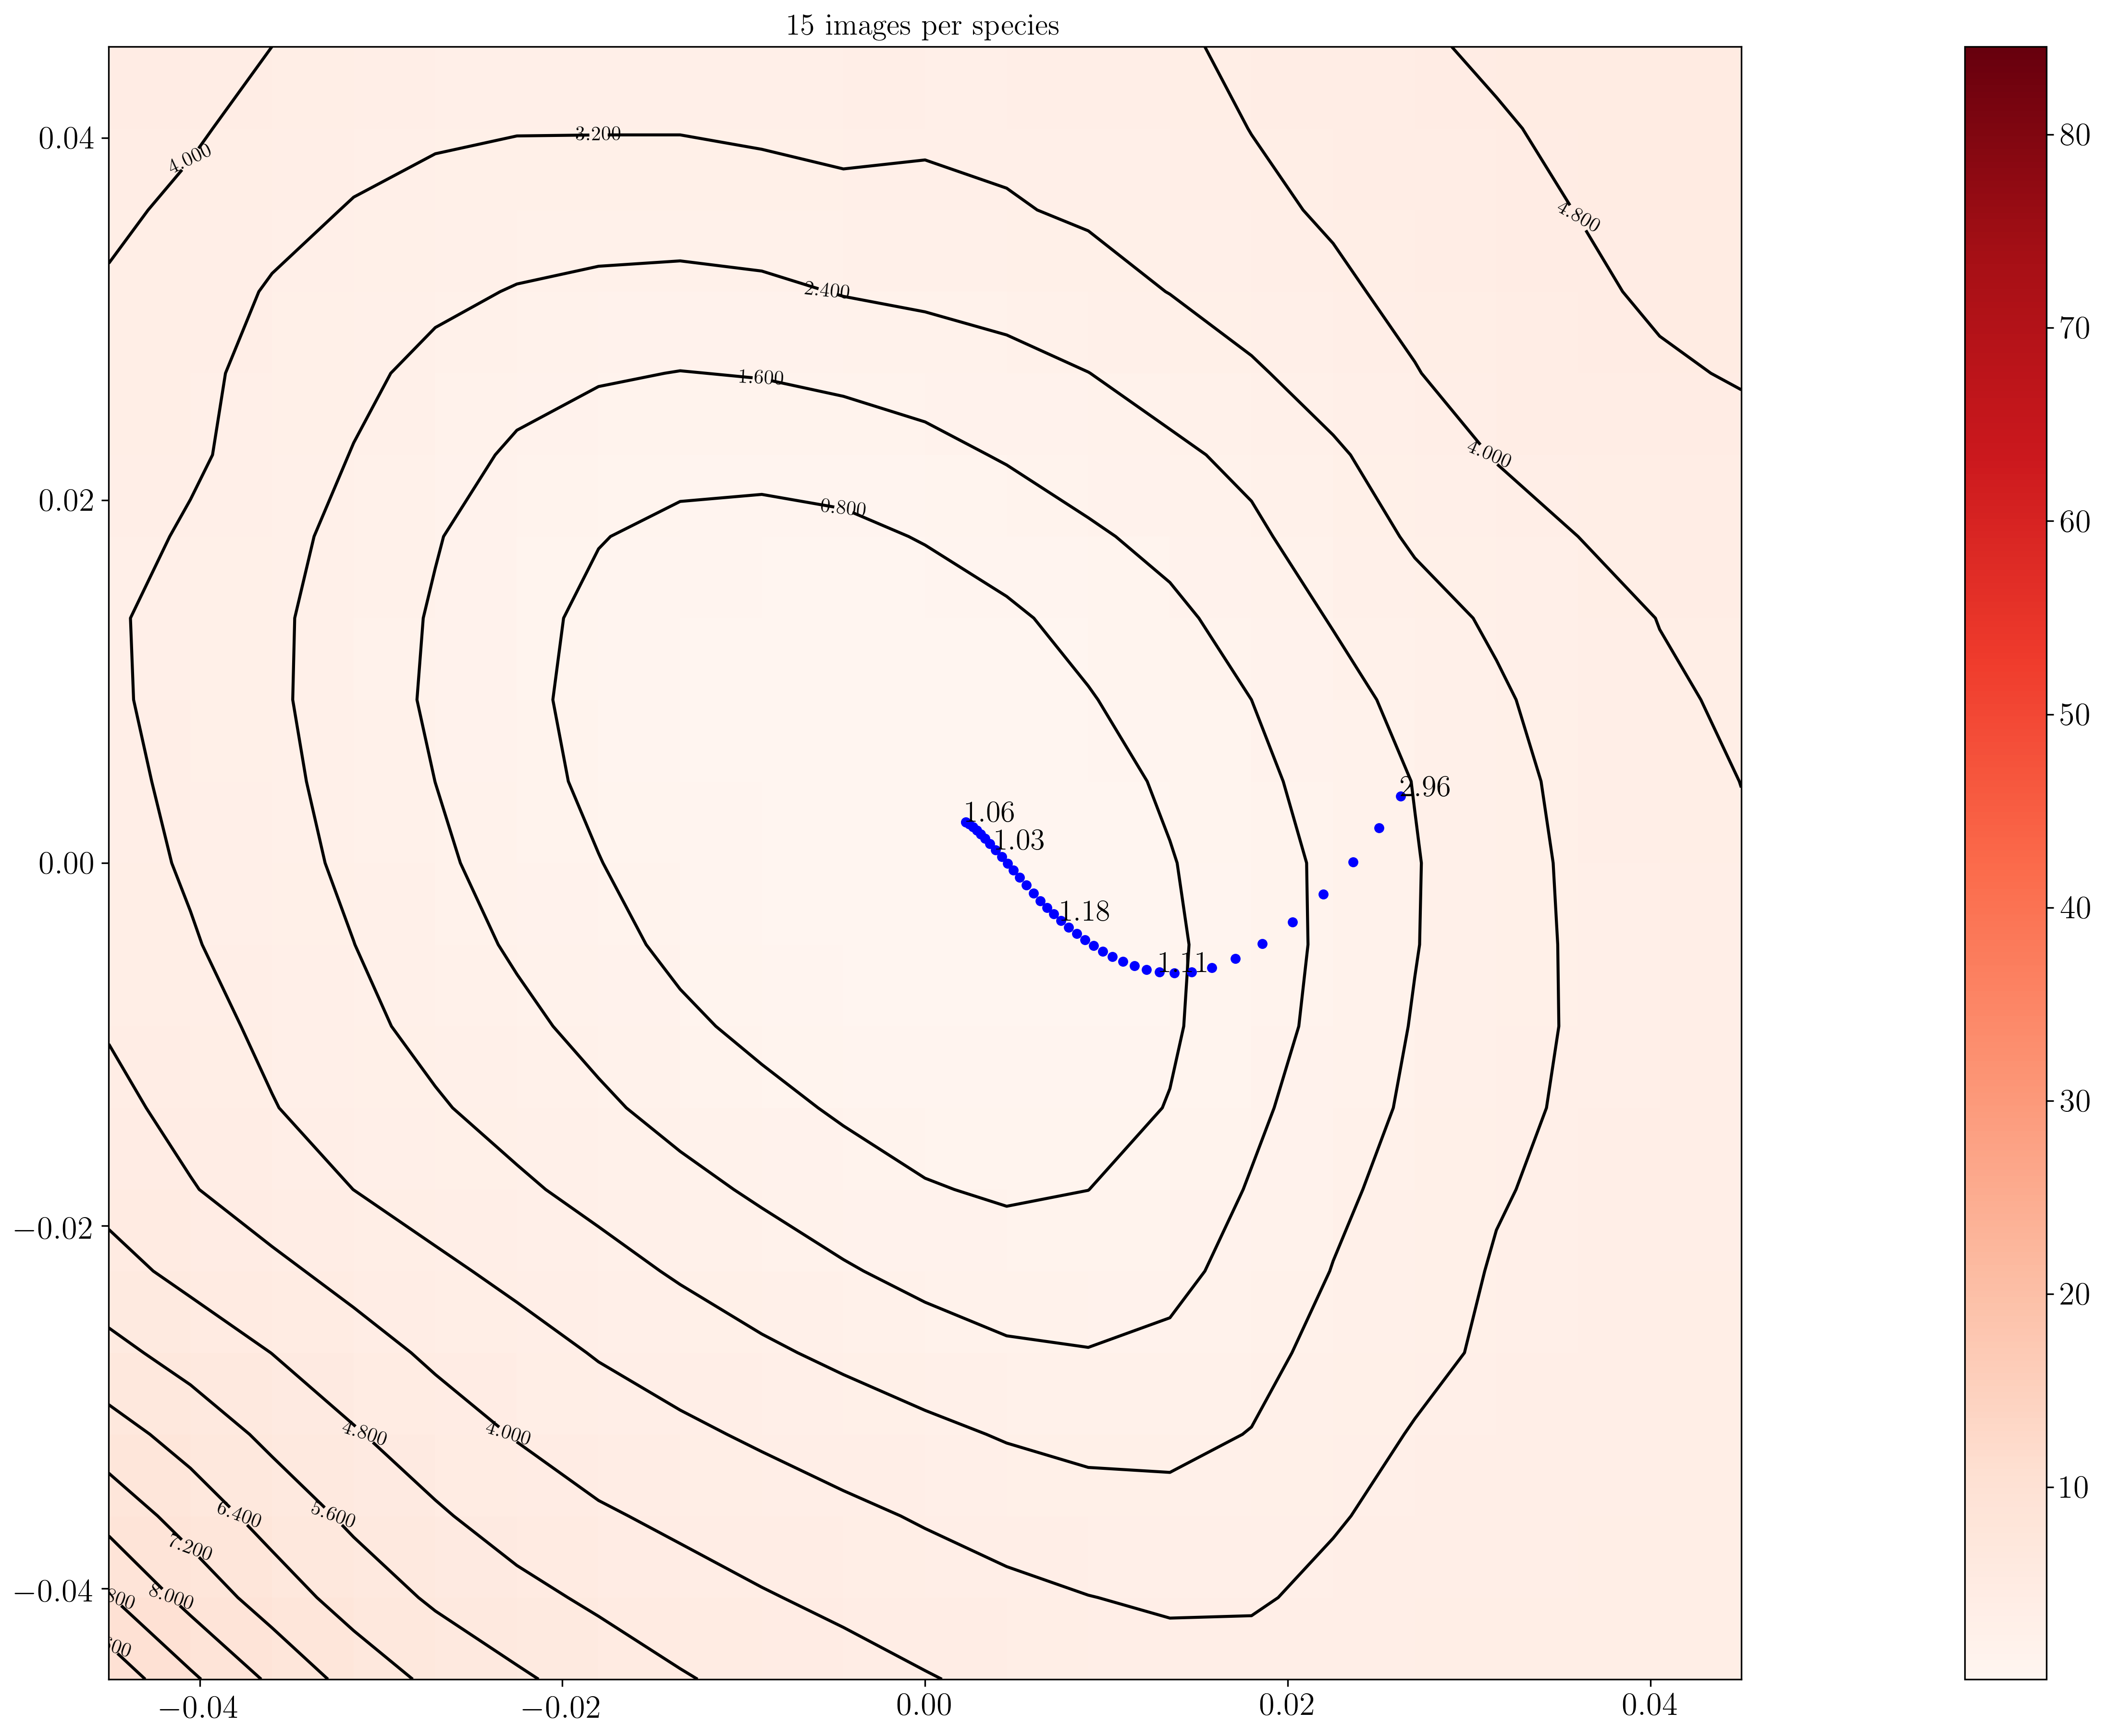

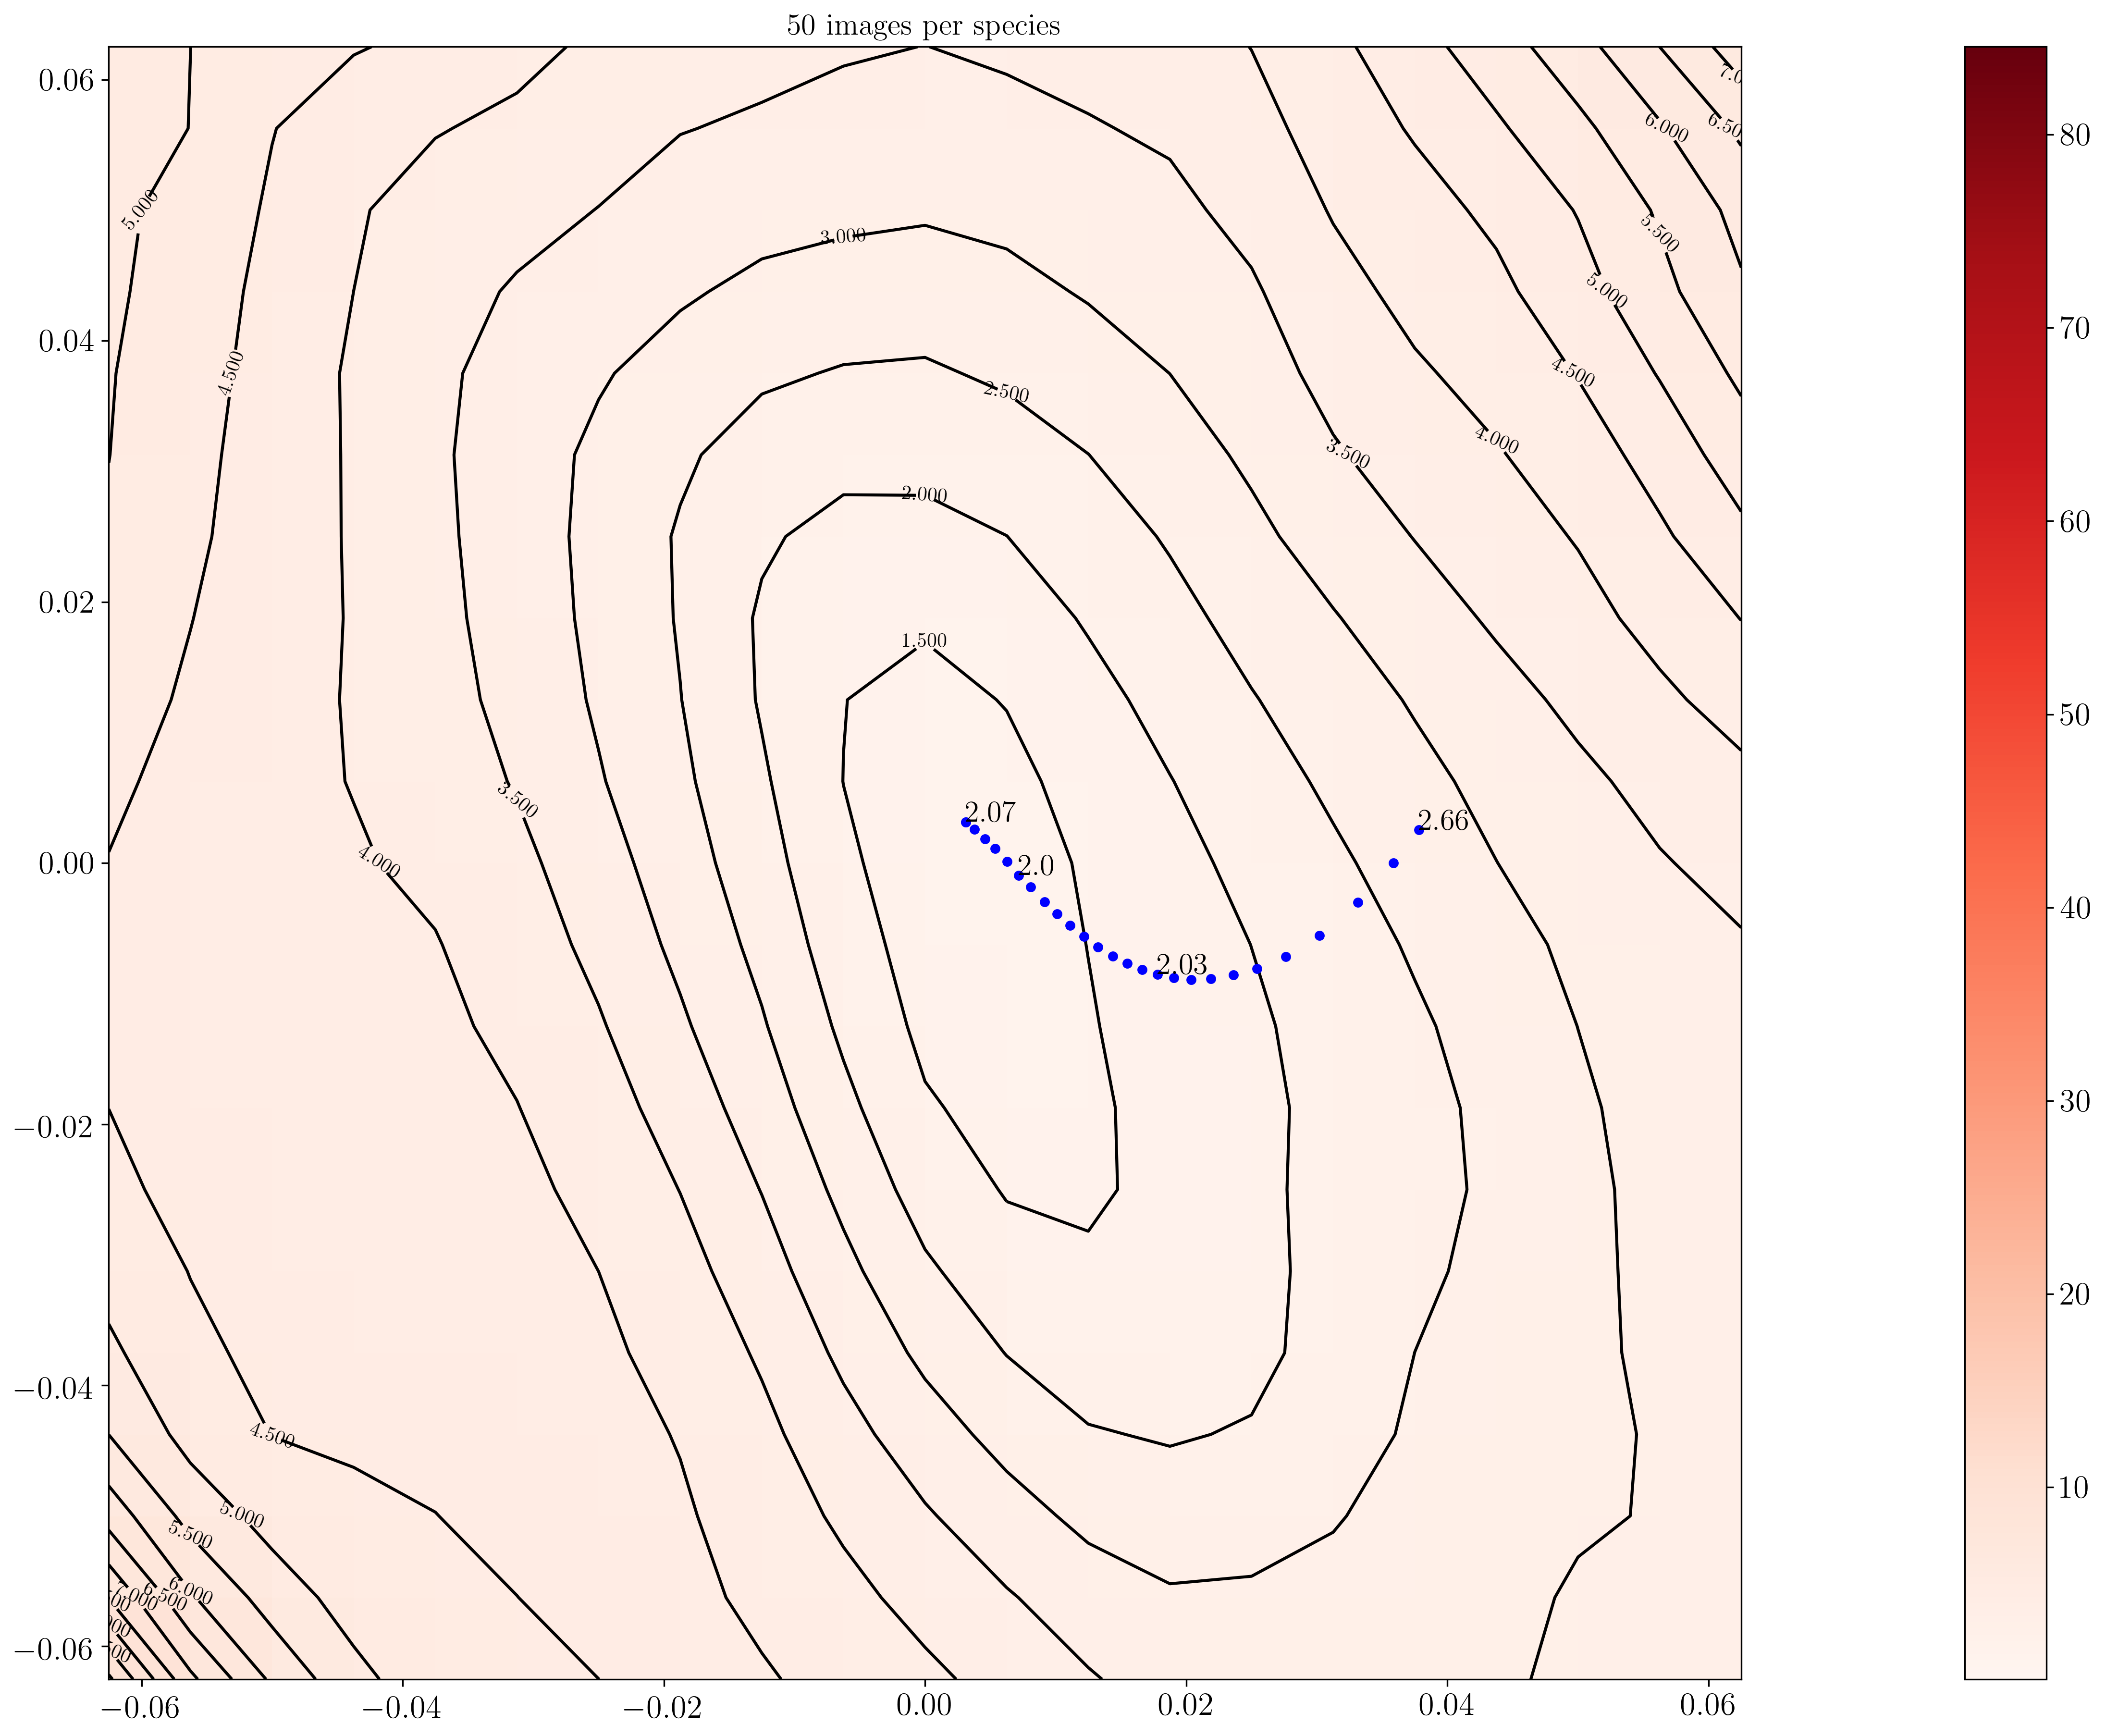

In [ ]:
# for all experiments
for experimentName, trial_hashes_ in tqdm(trial_hashes.items(), desc="experiment"):
    print("Experiment: ", experimentName)
    
    experimentPathAndName = os.path.join(experimentsPath, experimentName)
    config_parser = ConfigParser(experimentsPath, dataPath, experimentName)
    datasetManager = dataLoader.datasetManager(experimentPathAndName, dataPath)
    
    # For all models
    for hash_ in tqdm(trial_hashes_, desc="hash"):
        hash_, title_ = hash_
        print("Hash: ", hash_)
        
        # Get experiment parameters
        experiment_params = get_model_params(experimentPathAndName, hash_)
        datasetManager.updateParams(config_parser.fixPaths(experiment_params))
        train_loader, validation_loader, test_loader = datasetManager.getLoaders()
        architecture = {
            "fine": len(train_loader.dataset.csv_processor.getFineList()),
            "coarse" : len(train_loader.dataset.csv_processor.getCoarseList())
        }
        
        # Create paths for savign resutls
        model_path = get_model_path(experimentPathAndName, hash_)
        coord_Tracker_path = os.path.join(model_path, 'coordinates', normalize, str(STEPS), str(DISTANCE), loader_id)
        pca_path = os.path.join(model_path, 'coordinates')

        # get optimization path models
        model_root_path = os.path.join(experimentPathAndName, "models", hash_)
        model_paths = loss_surface_plotter.fetch_model_paths(model_root_path)
        models = loss_surface_plotter.get_models(model_paths, architecture, experiment_params)
        
        # plot and save      
        coord_Tracker = loss_landscapes.Coordinates_tracker(path=coord_Tracker_path, dirs_path=pca_path, steps_=STEPS, dist_=DISTANCE)                  
        loss_data_file = os.path.join(coord_Tracker_path, "loss_surface_data")
        coord_Tracker.load()
        loss_data = np.load(loss_data_file+'.npy')    
        print("loss surface data  loaded")
        f = plot_surface_data(loss_data, models, coord_Tracker, title_, max_, min_)  
        file_name = "surface_fig.pdf" if (not plot_all_on_same_scale) else "surface_fig_"+str(random.getrandbits(128))+".pdf"
        f.savefig(os.path.join(coord_Tracker_path, file_name))